install
1. muspy & pypianoroll via pip install in environment folder (e.g. /Users/kai/anaconda3/opt/envs/MusiCAN/bin)
2. fluidsynth via conda install -c conda-forge fluidsynth

In [ ]:
muspy.download_musescore_soundfont() # if you didn't do it already 

In [ ]:
muspy.download_bravura_font() # if you didn't do it already 

In [1]:
from IPython.display import clear_output, Audio, display
from ipywidgets import interact, IntSlider

import os
import os.path
import random
import datetime
import json

import numpy as np
import matplotlib.pyplot as plt
import torch
import pypianoroll
from pypianoroll import Multitrack, Track
from tqdm import tqdm # valuebar for iterations
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

import muspy

In [3]:
# create labels & id_list

genre_list = ['Rap', 'Latin', 'International', 'Electronic', 
              'Country', 'Folk', 'Blues', 'Reggae', 'Jazz',
              'Vocal', 'New-Age', 'RnB', 'Pop_Rock'] # genre <-> numeric label = index

id_list = [] # id = MillionSongsDataset ID
track_label_list = []
for path in os.listdir("unprepared_data/id_lists_amg"):
    filepath = "unprepared_data/id_lists_amg/" + path
    
    with open(filepath) as f:
        ids = [line.rstrip() for line in f]
        number_of_ids = len(ids)
        id_list.extend(ids)
    
    genre_no = genre_list.index(path[8:-4])
    track_label_list.extend([genre_no] * number_of_ids)  

In [4]:
# make sure no multiple genre label 
n = 0
id_array = np.array(id_list)
for id_1 in id_list:
    n_ids = np.sum(id_array == id_1)
    n += (n_ids - 1)
n == 0

True

In [5]:
# helper function

def msd_id_to_dirs(msd_id):
    """Given an MillionSongsDataset ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return(msd_id[2] + "/" + msd_id[3] + "/" + msd_id[4] + "/" + msd_id)

In [6]:
# helper function

def pianoroll_plot(multitrack):
    """Given muspy.multitrack object, plot part of pianoroll"""
    multitrack_copy = multitrack.copy()
    multitrack_copy.trim(end=12 * 96)
    axs = multitrack_copy.plot()
    plt.gcf().set_size_inches((16, 8))
    for ax in axs:
        for x in range(96, 12 * 96, 96):     
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
    plt.show()

In [16]:
# prepare data

# set values
n_pitches = 7*12  # number of pitches
lowest_pitch = 2*12  # MIDI note number of the lowest pitch
beat_resolution = 24  # temporal resolution of a beat (in timestep), 24 in data?
sample_size = 4 # number of beats per instance created by track-cropping
min_n_notes = 4 # minimal number of notes per instance

dataset_root = "unprepared_data/lpd_5/lpd_5_cleansed/"

# iterate over all the songs in the ID list
data_list = []
data_label_list = []

for i, msd_id in enumerate(tqdm(id_list)):
    
    # load multitrack as a pypianoroll.Multitrack instance
    song_dir = dataset_root + msd_id_to_dirs(msd_id)
    filename = os.listdir(song_dir)[0]
    multitrack = pypianoroll.load(song_dir + "/" + filename)
    
    # binarize pianorolls
    multitrack.binarize()
    
    # remove trailing silence: multitrack.trim()
    
    # downsample pianorolls (shape: time x pitches)
    multitrack.set_resolution(beat_resolution)

    # array conversion (shape: tracks x time x pitches) & extract piano track (= 2nd track) 
    pianoroll = multitrack.stack()[1,:,:]
    
    # fix pitch range
    pianoroll = pianoroll[:, lowest_pitch : lowest_pitch + n_pitches] # (shape: time x pitches))
    
    # crop pianoroll into smaller training samples
    n_timesteps = sample_size * beat_resolution # time steps per instance
    pianoroll = pianoroll[ : pianoroll.shape[0] - (pianoroll.shape[0] % n_timesteps), :] # make sure: number of total timesteps of track % n_timesteps == 0, else skip last bar
    pianoroll = pianoroll.reshape((-1, n_timesteps, n_pitches))
    
    # append instances with number of notes >= minimal number of notes (min_n_notes)
    good_instances_mask = (pianoroll.sum(axis = 1).sum(axis = 1) >= min_n_notes)
    data_list.append(pianoroll[good_instances_mask])
    
    # append labels
    data_label_list.extend([track_label_list[i]] * np.sum(good_instances_mask))
    
data_array = np.concatenate(data_list, axis = 0) # (shape: n_instances x n_timesteps x n_pitches)
label_array = np.array(data_label_list)
print(f"Successfully collect {len(data_array)} samples from {len(id_list)} songs")
print(f"Data shape : {data_array.shape}, {label_array.shape}")


# create unique file directory to save data
timestamp = datetime.datetime.now()
file_directory = f"./prepared_data/lpd5_{timestamp}"
os.makedirs(file_directory)
os.makedirs(file_directory + "/audio_examples") # for later..

# save preparation parameters as json file
prep_pars_dict = {"n_pitches": n_pitches,
                 "lowest_pitch": lowest_pitch,
                 "beat_resolution": beat_resolution, 
                  "beats_per_instance": sample_size,
                  "minimal_number_of_notes_per_instance": min_n_notes}
with open(file_directory + "/preparation_params.json", "w") as file:
    json.dump(prep_pars_dict, file, indent = 6)

# save data as compressed npz files
np.savez_compressed(file_directory + "/prepared_arrays.npz", data=data_array, labels=label_array)

100%|███████████████████████████████████████| 7323/7323 [03:48<00:00, 32.07it/s]


Successfully collect 388964 samples from 7323 songs
Data shape : (388964, 96, 84), (388964,)


In [17]:
# load data
batch_size = 10
file_directory = file_directory # change if wanted

loaded_data = np.load(file_directory + "/prepared_arrays.npz")
loaded_data_array, loaded_label_array = loaded_data["data"], loaded_data["labels"]

# convert to pytorch tensor
data_tensor = torch.as_tensor(loaded_data_array, dtype=torch.float32)
label_tensor = torch.as_tensor(loaded_label_array, dtype=torch.int)

# create pytorch dataset & dataloader
dataset = torch.utils.data.TensorDataset(data_tensor, label_tensor)
lpd5_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

  0%|                                                    | 0/15 [00:00<?, ?it/s]

Pop_Rock:


  7%|██▉                                         | 1/15 [00:03<00:52,  3.74s/it]

Pop_Rock:


 13%|█████▊                                      | 2/15 [00:07<00:49,  3.84s/it]

Pop_Rock:


 20%|████████▊                                   | 3/15 [00:11<00:46,  3.86s/it]

Pop_Rock:


 27%|███████████▋                                | 4/15 [00:15<00:42,  3.90s/it]

Latin:


 33%|██████████████▋                             | 5/15 [00:19<00:38,  3.89s/it]

RnB:


 40%|█████████████████▌                          | 6/15 [00:23<00:35,  3.90s/it]

RnB:


 47%|████████████████████▌                       | 7/15 [00:27<00:31,  3.90s/it]

Pop_Rock:


 53%|███████████████████████▍                    | 8/15 [00:31<00:27,  3.93s/it]

Latin:


 60%|██████████████████████████▍                 | 9/15 [00:35<00:23,  3.91s/it]

Pop_Rock:


 67%|████████████████████████████▋              | 10/15 [00:38<00:19,  3.90s/it]

Latin:


 73%|███████████████████████████████▌           | 11/15 [00:42<00:15,  3.91s/it]

Pop_Rock:


 80%|██████████████████████████████████▍        | 12/15 [00:46<00:11,  3.91s/it]

Pop_Rock:


 87%|█████████████████████████████████████▎     | 13/15 [00:50<00:07,  3.92s/it]

Country:


 93%|████████████████████████████████████████▏  | 14/15 [00:54<00:03,  3.91s/it]

Reggae:


100%|███████████████████████████████████████████| 15/15 [00:58<00:00,  3.89s/it]


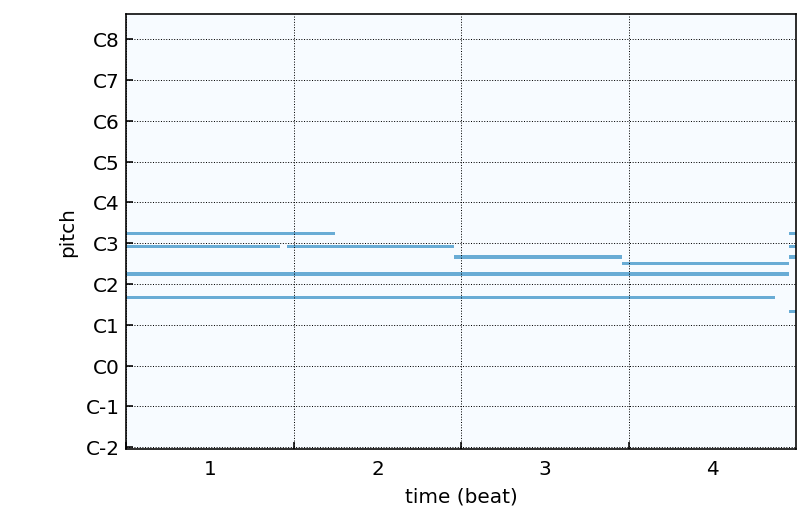

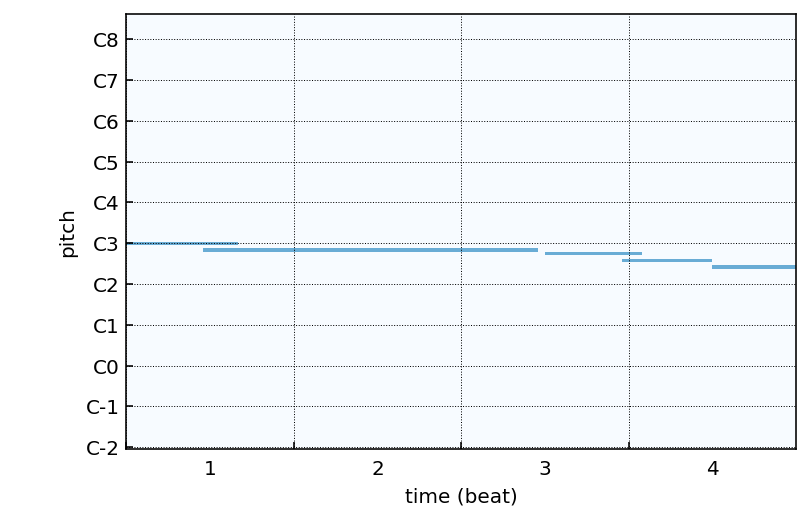

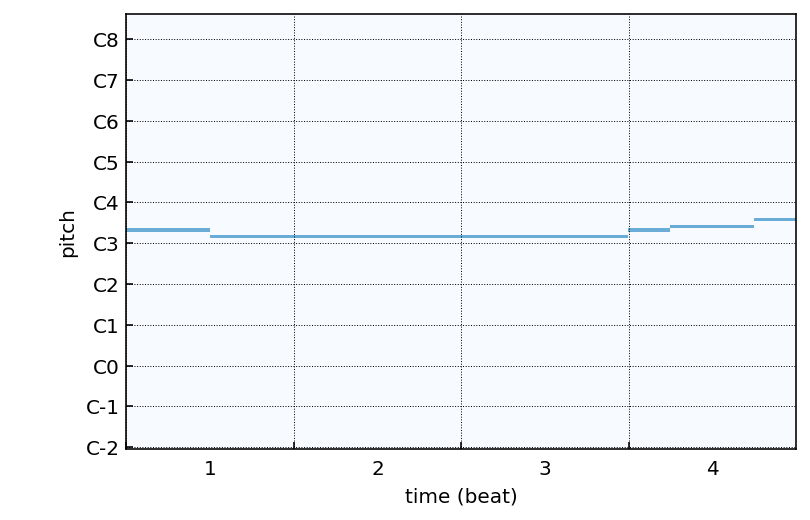

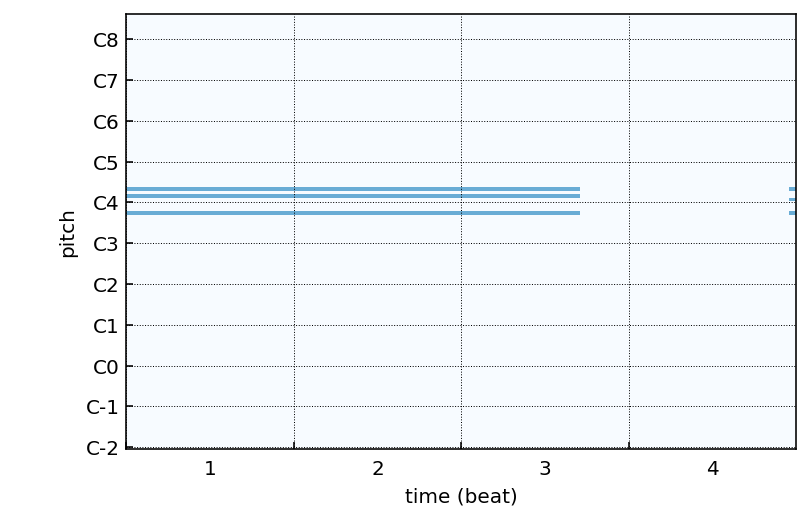

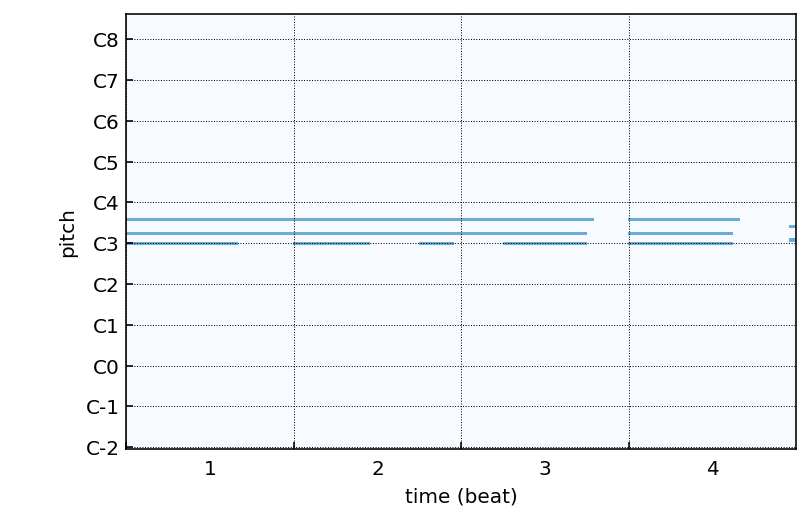

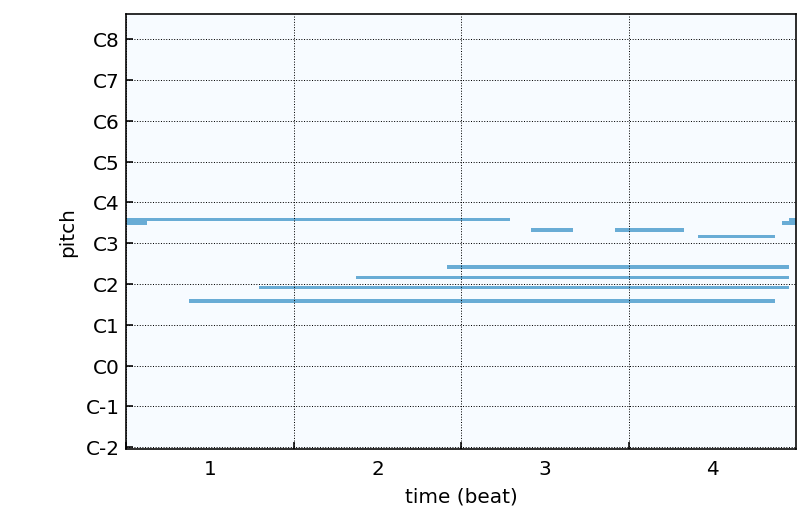

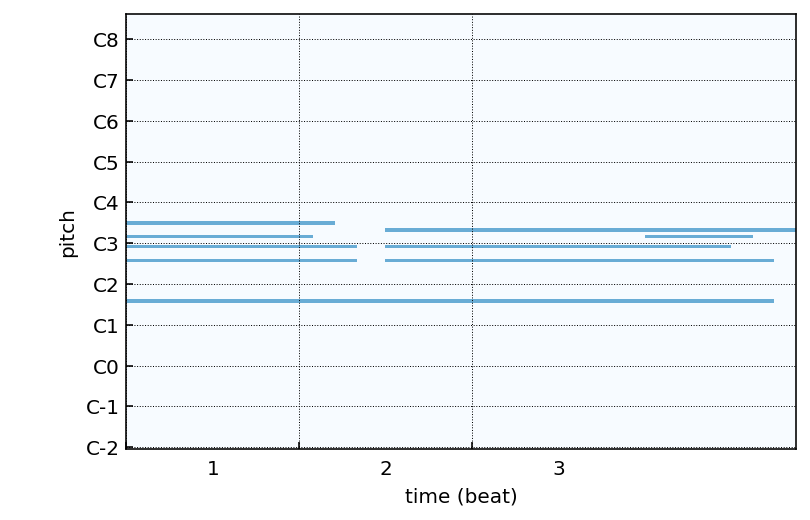

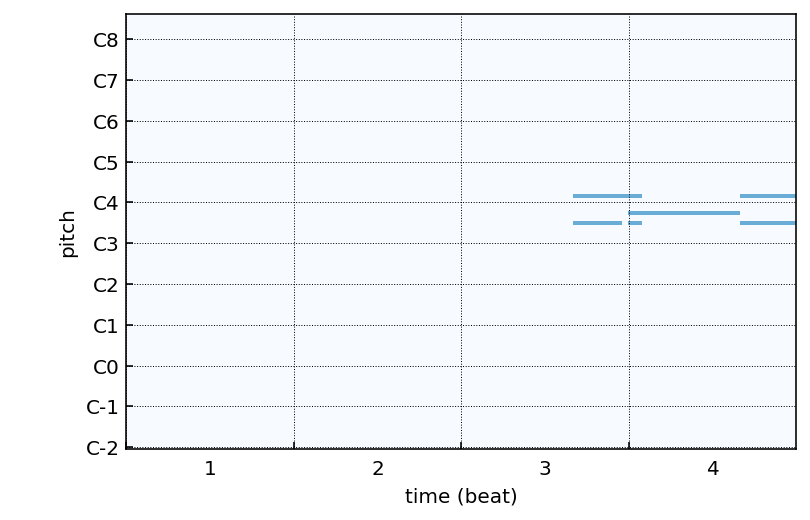

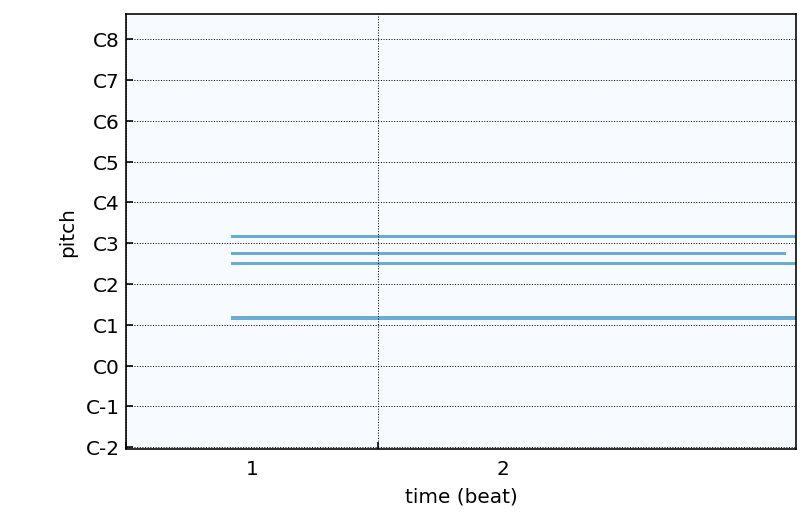

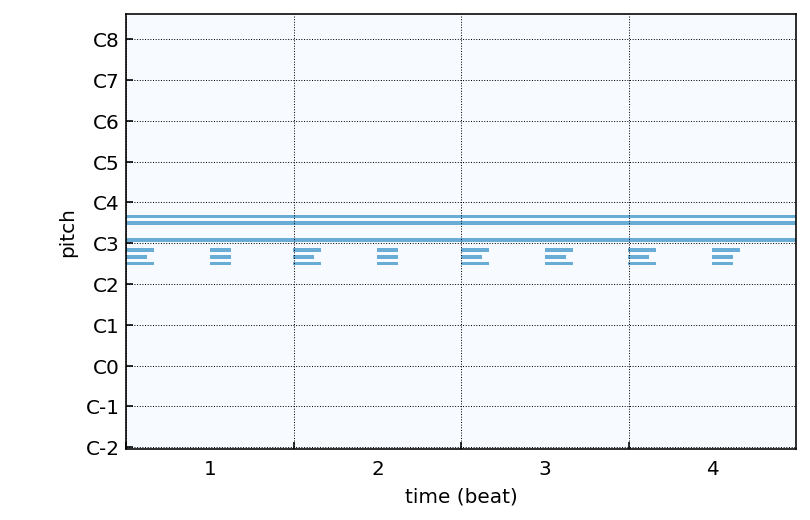

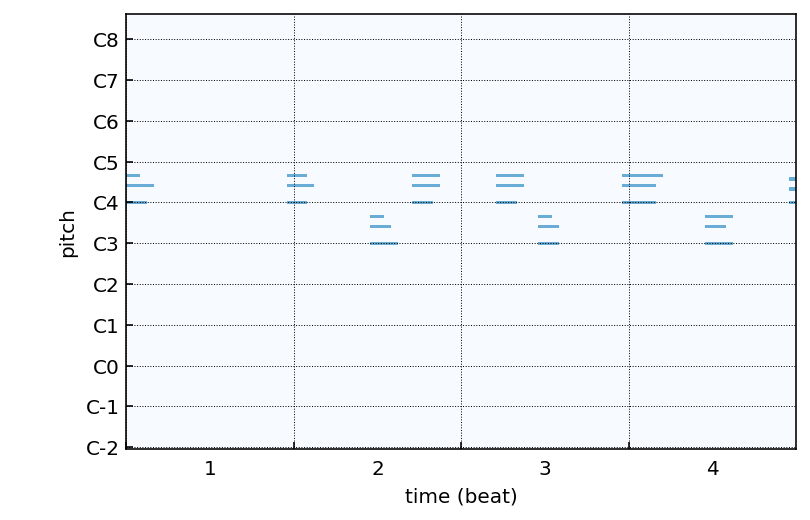

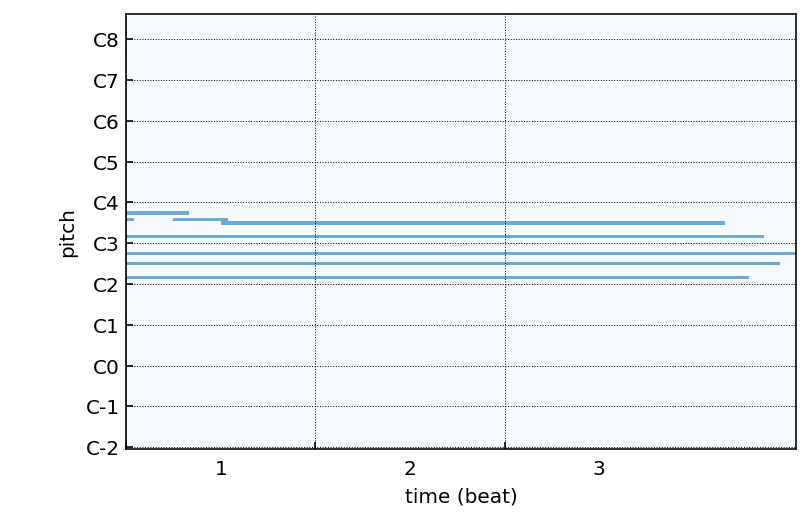

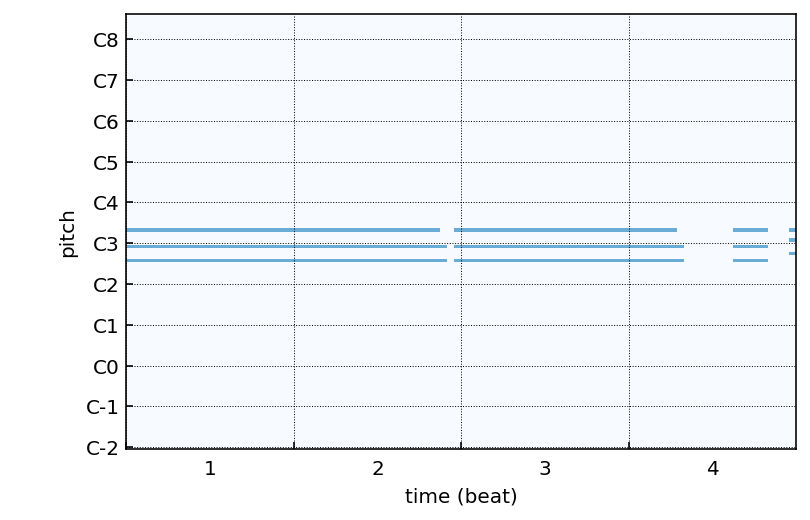

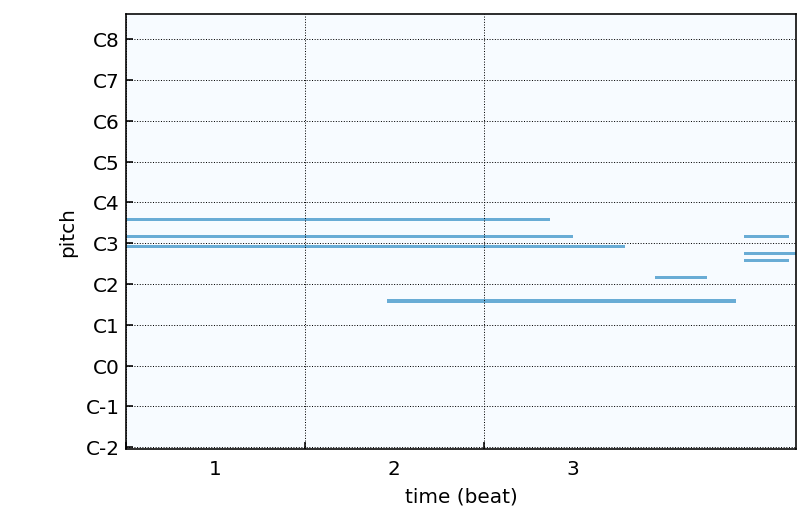

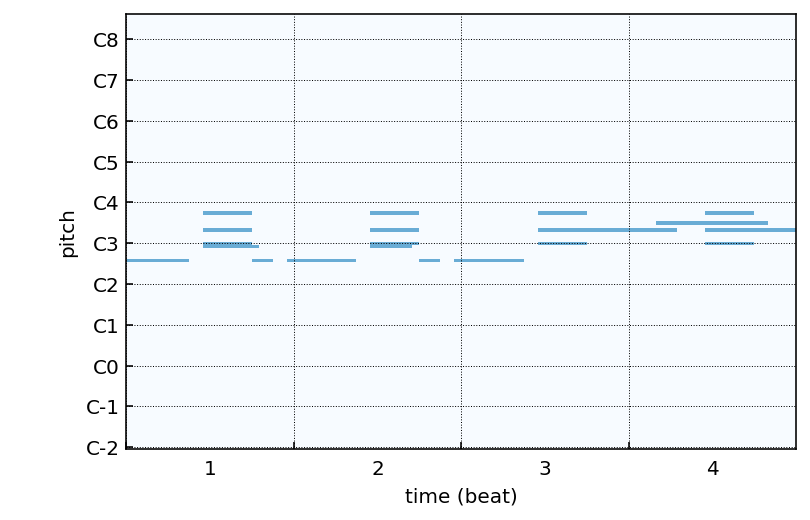

In [19]:
# convert random instances of loaded data to wave (audio) file & display them

n = 15 # number or random examples
rand_idxs = np.random.randint(0, len(loaded_label_array), n)

for i in tqdm(rand_idxs):
    X, y = loaded_data_array[i, :, :], loaded_label_array[i]
    
    genre_of_X = genre_list[y]
    
    X_padded = np.pad(X, ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches))) # complete pitch range
    X_music = muspy.from_pianoroll_representation(X_padded > 0, 
                resolution = beat_resolution, encode_velocity = False) # convert to muspy.music_object

    X_timestamp = datetime.datetime.now()
    muspy.write_audio(path = file_directory + f"/audio_examples/{genre_of_X}_{X_timestamp}.wav", 
                      music = X_music) 
    
    # display audio & show pianoroll
    print(genre_of_X + ":")
    display(Audio(filename = file_directory + f"/audio_examples/{genre_of_X}_{X_timestamp}.wav"))
    muspy.visualization.show_pianoroll(X_music)

['Rap', 'Latin', 'International', 'Electronic', 'Country', 'Folk', 'Blues', 'Reggae', 'Jazz', 'Vocal', 'New-Age', 'RnB', 'Pop_Rock']


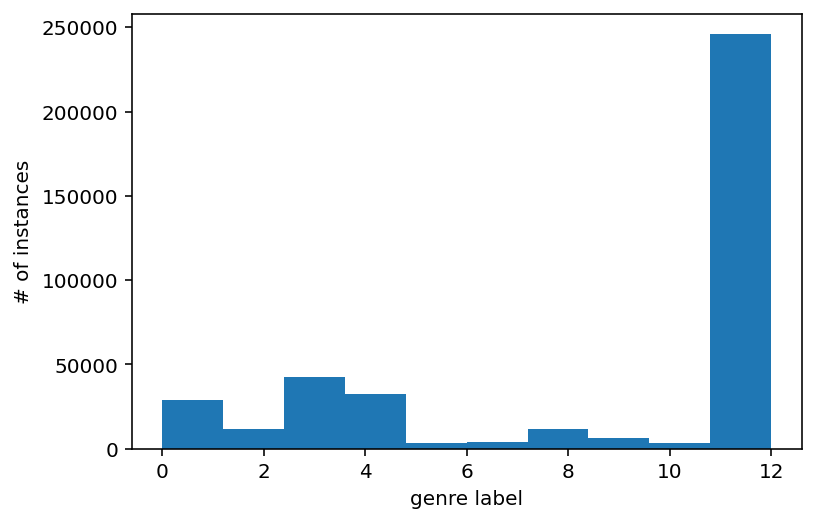

In [15]:
# number of data for each genre?

plt.hist(loaded_label_array)
plt.ylabel("# of instances")
plt.xlabel("genre label")

print(genre_list)